In [29]:
import nest_asyncio
nest_asyncio.apply()

In [30]:
import time
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import nest_asyncio
nest_asyncio.apply()
%matplotlib inline

In [31]:
import zipfile

def unzip_folder(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

# Usage example
zip_path = 'LettersData.zip'

unzip_folder(zip_path)

## Configuration and Hyperparameters

In [32]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['A', 'Ba', 'Da', 'Ga', 'Ha', 'Ja', 'Ka', 'La', 'Ma', 'Na', 'Pa', 'Ra', 'Ta', 'Tha', 'Wa', 'Ya']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if don't want to implement early stoping

train_path = 'LettersData/training/'
test_path = 'LettersData/testing/'
checkpoint_dir = "models/"

## Load Data

In [33]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading A files (Index: 0)
Loading Ba files (Index: 1)
Loading Da files (Index: 2)
Loading Ga files (Index: 3)
Loading Ha files (Index: 4)
Loading Ja files (Index: 5)
Loading Ka files (Index: 6)
Loading La files (Index: 7)
Loading Ma files (Index: 8)
Loading Na files (Index: 9)
Loading Pa files (Index: 10)
Loading Ra files (Index: 11)
Loading Ta files (Index: 12)
Loading Tha files (Index: 13)
Loading Wa files (Index: 14)
Loading Ya files (Index: 15)


In [34]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		522
- Validation-set:	99


In [35]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(np.array(image))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

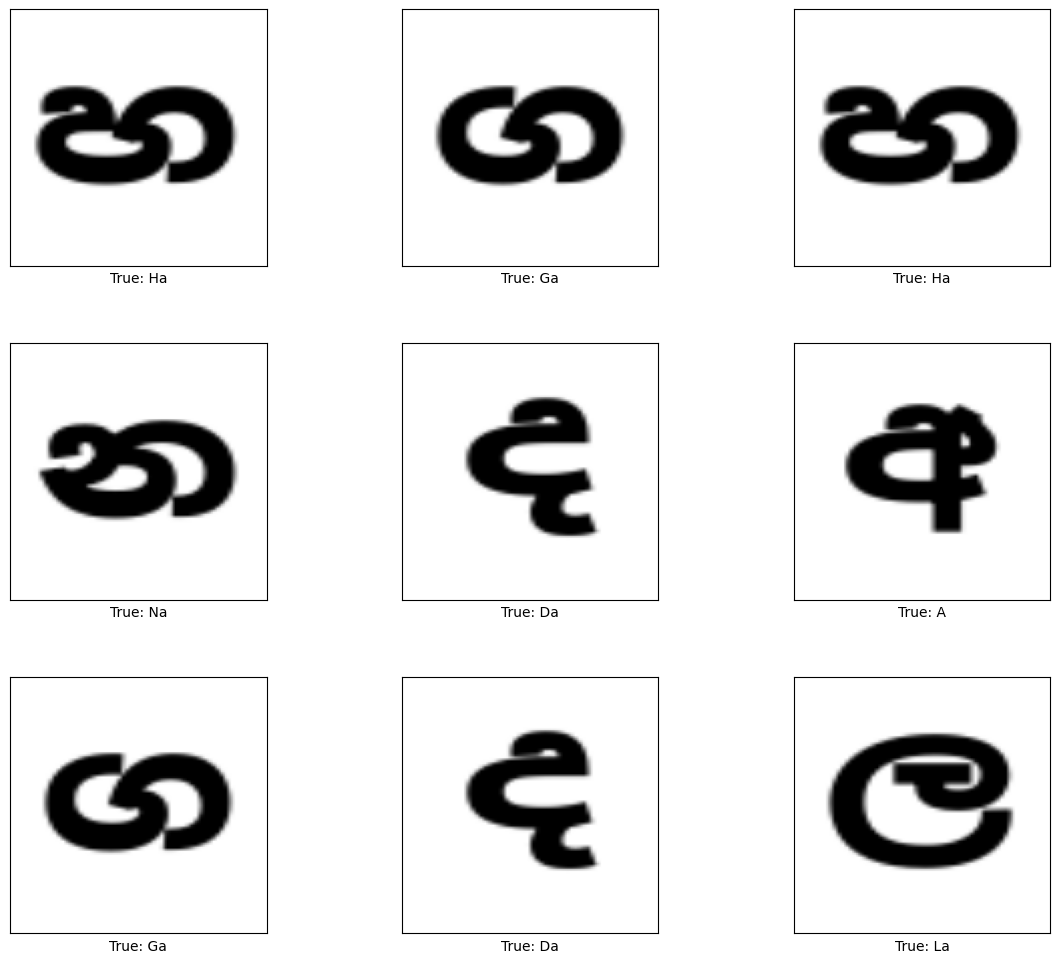

In [36]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Model

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(num_filters1, filter_size1, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(img_size, img_size, num_channels)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters2, filter_size2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters3, filter_size3, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_size, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [38]:
train_batch_size = batch_size

In [39]:
def print_progress(epoch, train_acc, val_acc, val_loss):
    msg = f"Epoch {epoch} --- Training Accuracy: {train_acc:>6.1%}, Validation Accuracy: {val_acc:>6.1%}, Validation Loss: {val_loss:.3f}"
    print(msg)

In [40]:
# Counter for total number of iterations performed so far.
total_iterations = 0
validation_accuracy = []
train_accuracy = []
validation_loss = []
train_loss = []

def train(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):
        # Reset the metric accumulators
        model.reset_metrics()

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        result = model.train_on_batch(x_batch, y_true_batch) 
        train_acc = result[1]
        
        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss, val_acc = model.test_on_batch(x_valid_batch, y_valid_batch, reset_metrics=False)
            validation_accuracy.append(val_acc)
            validation_loss.append(val_loss)
            train_accuracy.append(result[1])
            train_loss.append(result[0])
            epoch = int(i / int(data.train.num_examples/batch_size))
            metrics_names = model.metrics_names
            
            print_progress(epoch, train_acc, val_acc, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [41]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = np.argmax(model(images), 1)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

## Performance after 1 optimization iteration

In [42]:
train(num_iterations=1)
print_validation_accuracy()

Epoch 0 --- Training Accuracy:   3.1%, Validation Accuracy:   3.1%, Validation Loss: 6.012
Time elapsed: 0:00:02
Accuracy on Test-Set: 3.0% (3 / 99)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [43]:
results = train(num_iterations=99)

Epoch 1 --- Training Accuracy:  34.4%, Validation Accuracy:  56.2%, Validation Loss: 5.613
Epoch 2 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 5.041
Epoch 3 --- Training Accuracy: 100.0%, Validation Accuracy:  95.3%, Validation Loss: 4.205
Epoch 4 --- Training Accuracy:  96.9%, Validation Accuracy:  98.4%, Validation Loss: 3.350
Epoch 5 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 2.982
Epoch 6 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 2.797
Time elapsed: 0:01:11


In [44]:
print_validation_accuracy(show_example_errors=True)

Accuracy on Test-Set: 100.0% (99 / 99)


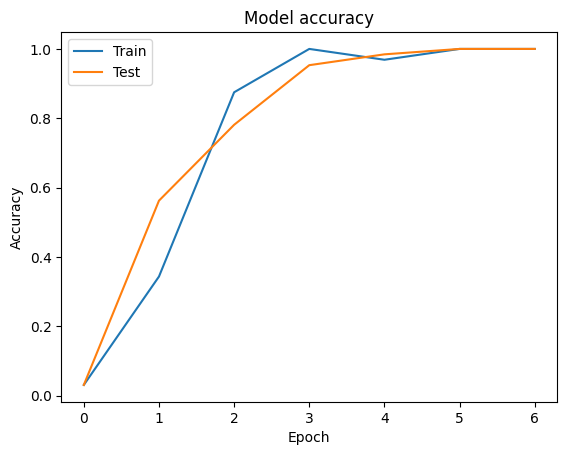

In [46]:
# Model Accuracy
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

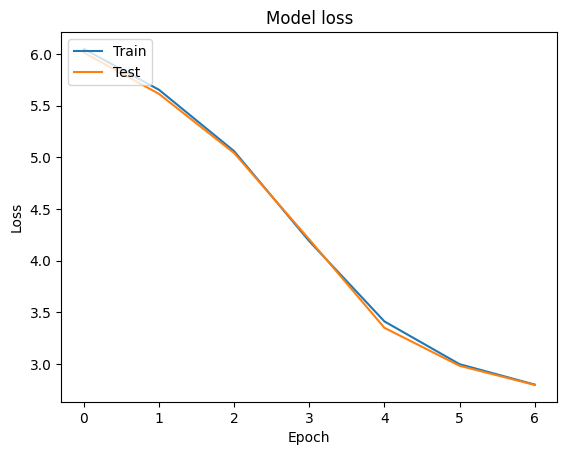

In [47]:
# model loss
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Save the Model

In [48]:
model.save('./model.h5')

# Load he Model

In [49]:
loaded_model = load_model('model.h5')

## Test on Sample Image

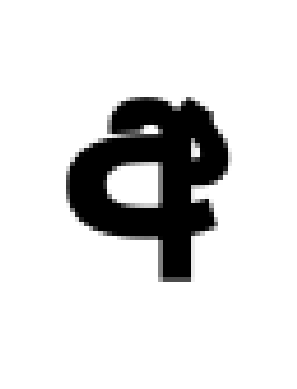

In [51]:
plt.axis('off')

test_img = cv2.imread('/content/LettersData/validation/A/A3 - Copy.png')

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

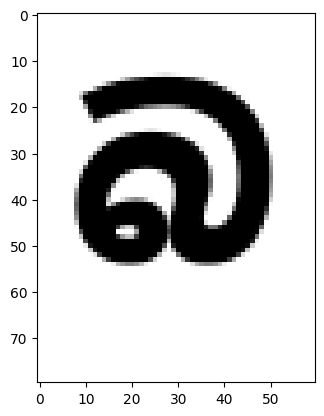

In [52]:
test_img1 = cv2.imread('/content/LettersData/validation/Ba/Ba1 - Copy.png')

plt.imshow(cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB))
plt.show()

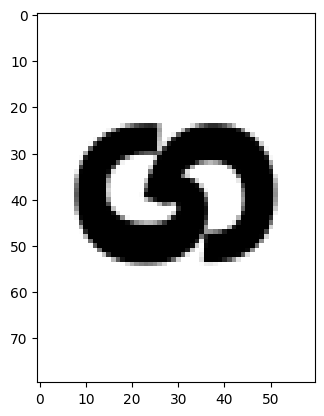

In [53]:
test_img2 = cv2.imread('/content/LettersData/validation/Ga/Ga1.png')

plt.imshow(cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB))
plt.show()

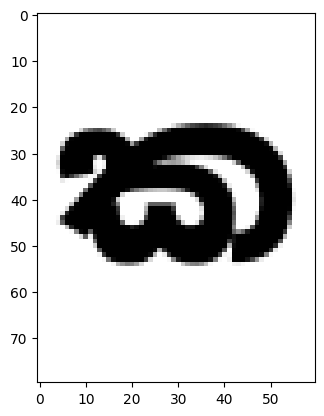

In [54]:
test_img3 = cv2.imread('/content/LettersData/validation/Ka/Ka0.png')

plt.imshow(cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB))
plt.show()

In [55]:
def sample_prediction(test_im):
    test_im = cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR) / 255
    test_pred = np.argmax(loaded_model(test_im.reshape((1, img_size, img_size, 3))))
    return classes[test_pred]

print("Predicted class for test_img: {}".format(sample_prediction(test_img)))
print("Predicted class for test_img1: {}".format(sample_prediction(test_img1)))
print("Predicted class for test_img2: {}".format(sample_prediction(test_img2)))
print("Predicted class for test_img3: {}".format(sample_prediction(test_img3)))

Predicted class for test_img: A
Predicted class for test_img1: Ba
Predicted class for test_img2: Ga
Predicted class for test_img3: Ka
